In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
from typing import NamedTuple, List

### Gaussian Bandit Environment

In [ ]:
class GaussianArm(NamedTuple):
  mean: float
  std: float


class Env:
  def __init__(self, num_arms: int, mean_reward_range: tuple, std: float):
    """
    num_arms: number of bandit arms
    mean_reward_range: mean reward of an arm should lie between
                       the given range
    std: standard deviation of the reward for each arm
    """
    self.num_arms = num_arms
    self.arms = self.create_arms(num_arms, mean_reward_range, std)
  
  def create_arms(self, n: int, mean_reward_range: tuple, std: float) -> dict:
    low_rwd, high_rwd = mean_reward_range
    # creates "n" number of mean reward for each arm
    means = np.random.uniform(low=low_rwd, high=high_rwd, size=(n,))
    arms = {id: GaussianArm(mu, std) for id, mu in enumerate(means)}
    return arms

  @property
  def arm_ids(self):
    return list(self.arms.keys())

  def step(self, arm_id: int) -> float:
    arm = self.arms[arm_id]
    return np.random.normal(arm.mean, arm.std)   # Reward

  def get_best_arm_and_expected_reward(self):
    best_arm_id = max(self.arms, key=lambda x: self.arms[x].mean)
    return best_arm_id, self.arms[best_arm_id].mean

  def get_avg_arm_reward(self):
    arm_mean_rewards = [v.mean for v in self.arms.values()]
    return np.mean(arm_mean_rewards)

  def plot_arms_reward_distribution(self, num_samples=1000):
    """
    This function is only used to visualize the arm's distrbution.
    """
    fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(9, 5))
    colors = sns.color_palette("hls", self.num_arms)
    for i, arm_id in enumerate(self.arm_ids):
      reward_samples = [self.step(arm_id) for _ in range(num_samples)]
      sns.histplot(reward_samples, ax=ax, stat="density", kde=True, bins=100, color=colors[i], label=f'arm_{arm_id}')
    ax.legend()
    plt.show()

### Policy

In [ ]:
class BasePolicy:
  @property
  def name(self):
    return 'base_policy'

  def reset(self):
    """
    This function resets the internal variable.
    """
    pass

  def update_arm(self, *args):
    """
    This function keep track of the estimates 
    that we may want to update during training.
    """
    pass

  def select_arm(self) -> int:
    """
    It returns arm_id
    """
    raise Exception("Not Implemented")

#### Random Policy

In [ ]:
class RandomPolicy(BasePolicy):
  def __init__(self, arm_ids: List[int]):
    self.arm_ids = arm_ids

  @property
  def name(self):
    return 'random'

  def reset(self) -> None:
    """No use."""
    pass

  def update_arm(self, *args) -> None:
    """No use."""
    pass

  def select_arm(self) -> int:
    return np.random.choice(self.arm_ids)

In [ ]:
class EpGreedyPolicy(BasePolicy):
  def __init__(self, epsilon: float, arm_ids: List[int]):
    self.epsilon = epsilon
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'ep-greedy ep:{self.epsilon}'

  def reset(self) -> None:
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    alpha = 1/(self.num_pulls_per_arm[arm_id] + 1)
    self.Q[arm_id] = self.Q[arm_id] + alpha*(arm_reward - self.Q[arm_id])
    self.num_pulls_per_arm[arm_id] += 1

  def select_arm(self) -> int:
    # your code for selecting arm based on epsilon greedy policy
    p = np.random.random()

    if p < self.epsilon:
      action_arm = np.random.choice(self.arm_ids)
    else:
      action_arm = np.argmax(list(self.Q.values()))
    
    return action_arm

In [ ]:
class SoftmaxPolicy(BasePolicy):
  def __init__(self, tau, arm_ids):
    self.tau = tau
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  @property
  def name(self):
    return f'softmax tau:{self.tau}'
  
  def reset(self):
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}

  def update_arm(self, arm_id: int, arm_reward: float) -> None:
    # your code for updating the Q values of each arm
    alpha = 1/(self.num_pulls_per_arm[arm_id] + 1)
    self.Q[arm_id] = self.Q[arm_id] + alpha*(arm_reward - self.Q[arm_id])
    self.num_pulls_per_arm[arm_id] += 1
    

  def select_arm(self) -> int:
    # your code for selecting arm based on softmax policy
    pi = np.array(list(self.Q.values()))/self.tau
    pi = np.exp(pi - np.max(pi))
    softmax_pi = pi/np.sum(pi)

    selected_arm = np.random.choice(self.arm_ids, p=softmax_pi)
    return selected_arm

In [ ]:
class UCB(BasePolicy):
  def __init__(self, arm_ids):
    self.arm_ids = arm_ids
    self.Q = {id: 0 for id in self.arm_ids}
    self.num_pulls_per_arm = {id:0 for id in self.arm_ids}
    
  @property
  def name(self):
    return 'UCB'

  def reset(self):
    self.num_pulls_per_arm = {id: 0 for id in self.arm_ids}
    self.Q = {id:0 for id in self.arm_ids}

  def update_arm(self, arm_id:int, arm_reward:float) -> None:
    alpha = 1/(self.num_pulls_per_arm[arm_id] + 1)
    self.Q[arm_id] = self.Q[arm_id] + alpha*(arm_reward - self.Q[arm_id])
    self.num_pulls_per_arm[arm_id] += 1

  def select_arm(self) -> int:
    
    for i in range(len(self.arm_ids)):
      if self.num_pulls_per_arm[i] == 0:
        return i

    num_pulls_per_arm = np.array(list(self.num_pulls_per_arm.values()))
    tot_pulls = np.sum(num_pulls_per_arm)

    confidence = np.sqrt(2*np.log(tot_pulls)/num_pulls_per_arm)
    objective = np.array(list(self.Q.values())) + confidence

    selected_arm = np.argmax(objective)

    return selected_arm

#### Trainer

In [ ]:
def train(env, policy: BasePolicy, timesteps):
  policy_reward = np.zeros((timesteps,))
  for t in range(timesteps):
    arm_id = policy.select_arm()
    reward = env.step(arm_id)
    policy.update_arm(arm_id, reward)
    policy_reward[t] = reward
  return policy_reward 


def avg_over_runs(env, policy: BasePolicy, timesteps, num_runs):
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  policy_reward_each_run = np.zeros((num_runs, timesteps))
  for run in range(num_runs):
    policy.reset()
    policy_reward = train(env, policy, timesteps)
    policy_reward_each_run[run, :] = policy_reward

  # calculate avg policy reward from policy_reward_each_run
  avg_policy_rewards = np.sum(policy_reward_each_run, axis = 0)/num_runs# your code here (type: nd.array, shape: (timesteps,))
  total_policy_regret = timesteps*expected_max_reward - np.sum(avg_policy_rewards) # your code here (type: float)
 
  return avg_policy_rewards, total_policy_regret

In [ ]:
def plot_reward_curve_and_print_regret(env, policies, timesteps=200, num_runs=500):
  fig, ax = plt.subplots(1, 1, sharex=False, sharey=False, figsize=(10, 6))
  for policy in policies:
    avg_policy_rewards, total_policy_regret = avg_over_runs(env, policy, timesteps, num_runs)
    print('regret for {}: {:.3f}'.format(policy.name, total_policy_regret))
    ax.plot(np.arange(timesteps), avg_policy_rewards, '-', label=policy.name)
  
  _, expected_max_reward = env.get_best_arm_and_expected_reward()
  ax.plot(np.arange(timesteps), [expected_max_reward]*timesteps, 'g-')
  
  avg_arm_reward = env.get_avg_arm_reward()
  ax.plot(np.arange(timesteps), [avg_arm_reward]*timesteps, 'r-')

  plt.legend(loc='lower right')
  plt.show()

### Experiments

In [ ]:
seed = 42
np.random.seed(seed)

num_arms = 5
mean_reward_range = (-25, 25)
std = 2.0

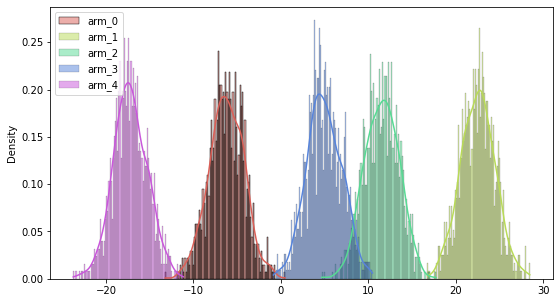

In [ ]:
env = Env(num_arms, mean_reward_range, std)

env.plot_arms_reward_distribution()

In [ ]:
best_arm, max_mean_reward = env.get_best_arm_and_expected_reward()
print(best_arm, max_mean_reward)

1 22.53571532049581


In [ ]:
print(env.get_avg_arm_reward())

3.119254917081568


#### Please explore following values:

- Epsilon greedy: [0.001, 0.01, 0.5, 0.9]
- Softmax: [0.001, 1.0, 5.0, 50.0]

regret for random: 3871.625


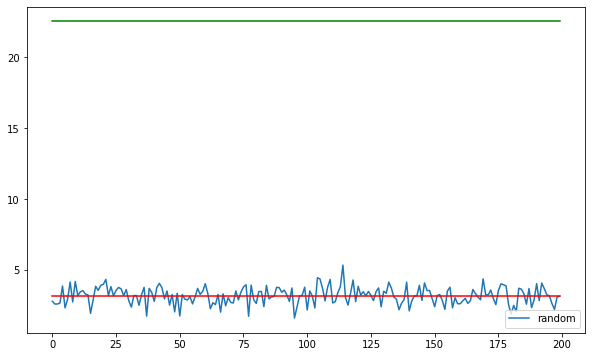

In [ ]:
random_policy = RandomPolicy(env.arm_ids)
plot_reward_curve_and_print_regret(env, [random_policy], timesteps=200, num_runs=500)

regret for ep-greedy ep:0.001: 30.776
regret for ep-greedy ep:0.01: 80.004
regret for ep-greedy ep:0.5: 1978.051
regret for ep-greedy ep:0.9: 3505.293


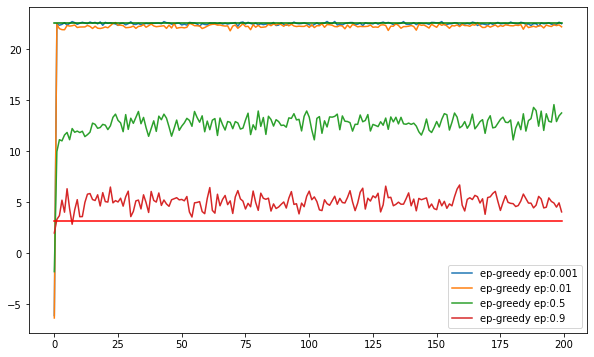

In [ ]:
explore_epgreedy_epsilons =  [0.001, 0.01, 0.5, 0.9]
epgreedy_policies = [EpGreedyPolicy(ep, env.arm_ids) for ep in explore_epgreedy_epsilons]
plot_reward_curve_and_print_regret(env, epgreedy_policies, timesteps=200, num_runs=500)

regret for softmax tau:0.001: 1885.205
regret for softmax tau:1.0: 1341.553
regret for softmax tau:5.0: 413.699
regret for softmax tau:50.0: 3166.404


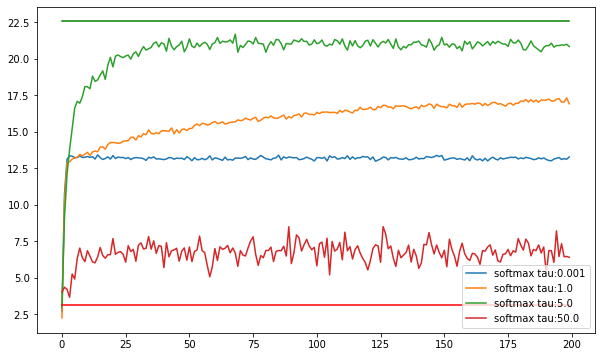

In [ ]:
explore_softmax_taus =  [0.001, 1.0, 5.0, 50.0]
softmax_polices = [SoftmaxPolicy(tau, env.arm_ids) for tau in explore_softmax_taus]
plot_reward_curve_and_print_regret(env, softmax_polices, timesteps=200, num_runs=500)

regret for UCB: 94.507


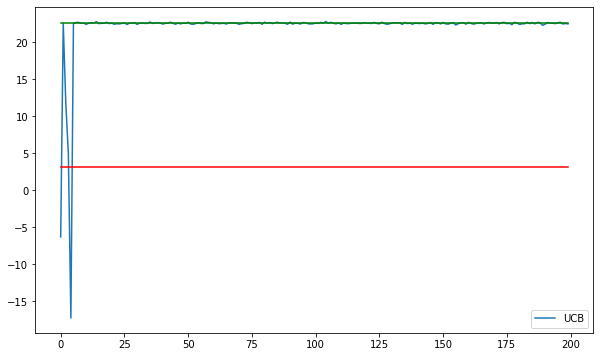

In [ ]:
plot_reward_curve_and_print_regret(env, [UCB(env.arm_ids)], timesteps=200, num_runs=500)

#### Optional: Please explore different values of epsilon, tau and verify how does the behaviour changes.